Adrian Gruszczynski / Yann Salimi

# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp

In [18]:
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.alpha = 0
        self.n_features = 0
        self.n_samples = 0

    @property
    def _is_initialized(self):
        return self.weights is not None

    def sigmoid(self, x):
        return (1 / (1 + np.exp(-x)) >= .5).astype(np.int8)

    #  cross entropy gradient
    def grad_ce(self, X, y):
        h = self.sigmoid(X @ self.weights)
        self.weights -= self.alpha * (X.T @ (h - y) / self.n_samples)

    # cross entropy loss function
    def loss_ce(self, X, y):
        h = self.sigmoid(X @ self.weights)
        return ((- 1 * y.T @ np.log(h + 1e-12)) - 
                ((1 - y).T @ np.log(1 - h + 1e-12))) / self.n_samples

    # mean square error loss function
    def loss_mse(self, X, y):
        h = self.sigmoid(X @ self.weights)
        return np.sum(np.square(h - y)) / self.n_samples

    # mean square error loss gradient
    def grad_mse(self, X, y):
        h = self.sigmoid(X @ self.weights)
        self.weights -= self.alpha * (2 * np.sum((h - y) @ X)) / self.n_samples

    def fit(self, X, y, alpha, n_iter, X_val, y_val, optimizer):
        self.n_samples, self.n_features = X.shape
        self.alpha = alpha
        fig, (ax1, ax2) = plt.subplots(2, 1)

        if optimizer == 'MSE':
            self.weights = np.random.normal(0, .00001, X.shape[1])
            for i in range(n_iter):
                for batch in iterate_minibatches(X, y, 100, shuffle=True):
                    x_batch, y_batch = batch
                    self.grad_mse(x_batch, y_batch)
                loss = self.loss_mse(x_batch, y_batch)
                h = self.sigmoid(X_val @ self.weights)
                ax1.scatter(i, loss, c='b')
                ax1.set_ylabel('Loss')
                ax2.scatter(i, 100 * accuracy_score(h, y_val), c='y')
                ax2.set_ylabel('Val accuracy in %')
                ax2.set_xlabel('No. iterations')
            y_pred = self.sigmoid(X_val @ self.weights)
            accuracy = 100 * accuracy_score(y_val, y_pred)
            fig.suptitle('MSE')
            plt.show()
            print('MSE accuracy: %.2f%%' % accuracy)

        elif optimizer == 'CE':
            self.weights = np.random.normal(0, .001, X.shape[1])
            for i in range(n_iter):
                for batch in iterate_minibatches(X, y, 100, shuffle=True):
                    x_batch, y_batch = batch
                    self.grad_ce(x_batch, y_batch)
                loss = self.loss_ce(x_batch, y_batch)
                h = self.sigmoid(X_val @ self.weights)
                ax1.scatter(i, loss, c='b')
                ax1.set_ylabel('Loss')
                ax2.scatter(i, 100 * accuracy_score(h, y_val), c='y')
                ax2.set_ylabel('Val accuracy in %')
                ax2.set_xlabel('No. iterations')
            y_pred = self.sigmoid(X_val @ self.weights)
            accuracy = 100 * accuracy_score(y_val, y_pred)
            fig.suptitle('Cross-entropy')
            plt.show()
            print('Cross entropy accuracy: %.2f%%' % accuracy)

        else:
            raise ValueError('specified optimizer not found')


In [4]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


def accuracy_score(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError('array shapes do not match')
    return np.sum(np.equal(y_true, y_pred)) / len(y_true)


def unison_shuffle(a, b):
    if len(a) != len(b):
        raise ValueError('array lengths do not match')
    idx = np.random.permutation(len(a))
    return a[idx], b[idx]

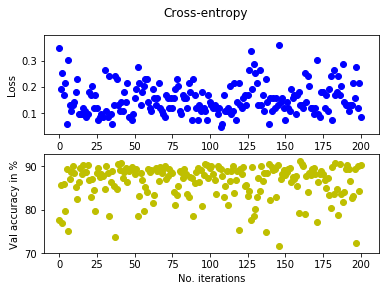

Cross entropy accuracy: 90.27%


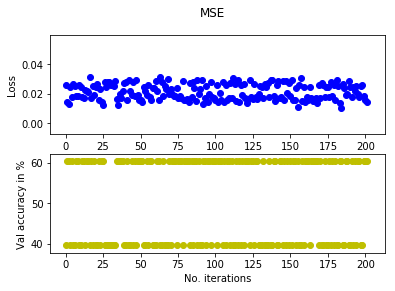

MSE accuracy: 60.32%


In [15]:
if __name__ == '__main__':
    np.random.seed(123456)

    df = np.array(pd.read_csv('spambase.data', header=None))

    X, y = df[:, :-1], df[:, -1].astype(np.bool_)
    X, y = unison_shuffle(X, y)

    scaler = sp.MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X)
    X = scaler.transform(X)

    split = len(X) // 2

    X_train, y_train = X[:split], y[:split]
    X_val, y_val = X[split:], y[split:]

    lr = LogisticRegression()
    lr.fit(X_train, y_train, 1, 201, X_val, y_val, 'CE')
    lr.fit(X_train, y_train, .1, 202, X_val, y_val, 'MSE')

## (a) Try both Cross Entropy and Squared Error as loss functions. Compare the results and explain the difference.

The difference in results is caused by the fact, that MSE in neural networks, in opposite to cross-entropy, is not a convex function. Logistic regression can be seen as a special case of neural network with no hidden layers.

Thus using cross-entropy gradient results in converging towards the global minimum whereas using MSE gradient can result in convergence towards local minimum.

## (b) Assuming that the labels are from the set {1, −1}, how would you modify the activation function without changing the label-values?

We could use $tanh(x)$ as the activation function and map every $x<0$ to $-1$ and $x\geq0$ to 1 respectively.